In [ ]:
# --- Core Data Handling and Utilities ---
import pandas as pd
import numpy as np
import os
import re # Used for text cleaning (if needed)
import matplotlib.pyplot as plt # For visualization of training history
# You only need the 'kagglehub' import if you are executing the download step
# import kagglehub 

# --- Machine Learning and Metrics ---
from sklearn.model_selection import train_test_split # Splitting data
from sklearn.preprocessing import LabelEncoder # Encoding text labels
from sklearn.linear_model import LogisticRegression # For the baseline model
from sklearn.metrics import classification_report # For performance evaluation

# --- PyTorch and Hugging Face Transformers ---
import torch
from torch.utils.data import Dataset, DataLoader # PyTorch data pipeline
from torch.optim import AdamW # The optimizer for BERT fine-tuning
from transformers import BertTokenizer, BertForSequenceClassification # BERT model components
from transformers import GPT2Tokenizer, GPT2Model # GPT-2 model components (for LR features)
from tqdm import tqdm # For showing progress bars during training/evaluation
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\25769\.cache\kagglehub\datasets\suchintikasarkar\sentiment-analysis-for-mental-health\versions\1


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch
from torch.optim import AdamW
from tqdm.notebook import tqdm # For tracking training progress

file_name = "Combined Data.csv"
file_path = os.path.join(path, file_name)

print(f"Attempting to load data from: {file_path}")

# --- 1. Load Data (Assumed Cleaned Data) ---
# Assuming 'df' is the cleaned DataFrame from the previous step (no NaN in 'statement')
# For demonstration, we reload and clean:
try:
    df = pd.read_csv(file_path)
    df = df.drop(columns=['Unnamed: 0'])
    df.dropna(subset=['statement'], inplace=True)
except Exception:
    print("Could not load data from path, please ensure file path is correct.")
    # Fallback to a placeholder if loading fails
    # df = pd.DataFrame({'statement': ["example statement", "another one"], 'status': ["Normal", "Depression"]})


# --- 2. Label Encoding ---
le = LabelEncoder()
df['status_encoded'] = le.fit_transform(df['status'])

# Get the number of unique classes
NUM_LABELS = len(le.classes_)

# Map for decoding results later
label_map = {i: label for i, label in enumerate(le.classes_)}
print(f"Number of classes (NUM_LABELS): {NUM_LABELS}")


# --- 3. Data Splitting ---
train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=42, 
    stratify=df['status_encoded']
)

print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}")

Attempting to load data from: C:\Users\25769\.cache\kagglehub\datasets\suchintikasarkar\sentiment-analysis-for-mental-health\versions\1\Combined Data.csv
Number of classes (NUM_LABELS): 7
Train samples: 42144, Validation samples: 10537


In [8]:
# Initialize BERT Tokenizer
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
MAX_LEN = 128 # Set maximum sequence length, adjust based on data analysis

# --- 4. Custom Dataset Class for BERT ---

class MentalHealthDataset(Dataset):
    """A custom PyTorch Dataset for loading and tokenizing the text data."""
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True, # Add [CLS] and [SEP]
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt', # Return PyTorch tensors
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create Dataset and DataLoader
train_dataset = MentalHealthDataset(
    train_df['statement'], 
    train_df['status_encoded'], 
    tokenizer, 
    MAX_LEN
)

val_dataset = MentalHealthDataset(
    val_df['statement'], 
    val_df['status_encoded'], 
    tokenizer, 
    MAX_LEN
)

BATCH_SIZE = 16 # Adjust based on your GPU memory
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Optimizer AdamW initialized successfully.

--- Starting BERT Fine-tuning ---

Epoch 1/3


Training: 100%|██████████| 2634/2634 [09:22<00:00,  4.69it/s]


Train loss 0.5909 | Accuracy 0.7703


Validation: 100%|██████████| 659/659 [01:07<00:00,  9.78it/s]


Val loss   0.4423 | Accuracy 0.8179
Model saved! New best accuracy: 0.8179

Epoch 2/3


Training: 100%|██████████| 2634/2634 [09:27<00:00,  4.64it/s]


Train loss 0.3627 | Accuracy 0.8519


Validation: 100%|██████████| 659/659 [01:06<00:00,  9.87it/s]


Val loss   0.4127 | Accuracy 0.8313
Model saved! New best accuracy: 0.8313

Epoch 3/3


Training: 100%|██████████| 2634/2634 [09:20<00:00,  4.70it/s]


Train loss 0.2580 | Accuracy 0.8964


Validation: 100%|██████████| 659/659 [01:09<00:00,  9.46it/s]


Val loss   0.4415 | Accuracy 0.8301

--- Plotting Training History ---


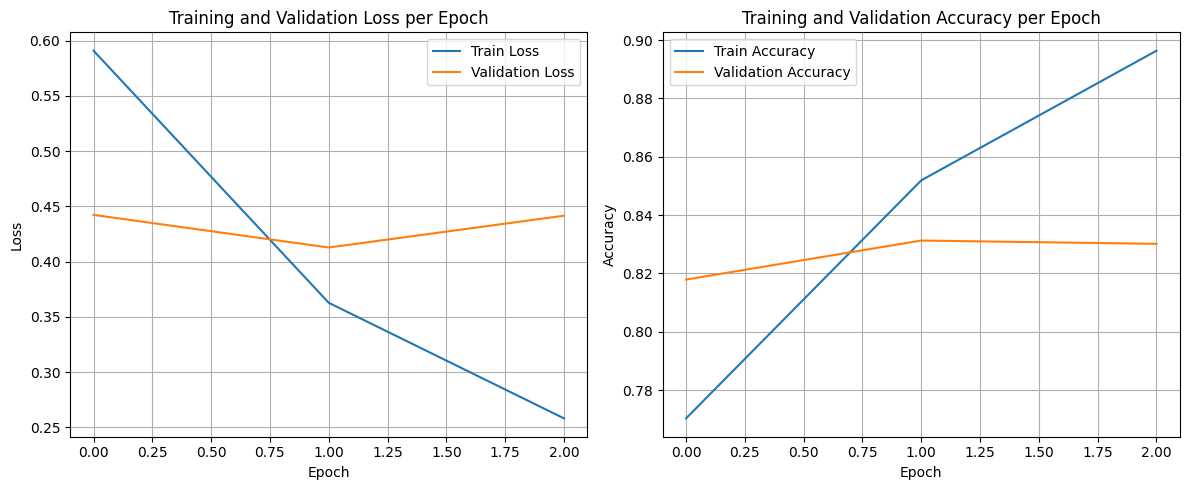


--- Final Evaluation on Validation Set (Using Best Model) ---


Validation: 100%|██████████| 659/659 [01:06<00:00,  9.93it/s]


--- Classification Report (Best Model) ---
                      precision    recall  f1-score   support

             Anxiety       0.84      0.90      0.87       768
             Bipolar       0.90      0.83      0.87       556
          Depression       0.79      0.77      0.78      3081
              Normal       0.95      0.96      0.96      3269
Personality disorder       0.63      0.78      0.69       215
              Stress       0.77      0.72      0.74       517
            Suicidal       0.72      0.73      0.72      2131

            accuracy                           0.83     10537
           macro avg       0.80      0.81      0.81     10537
        weighted avg       0.83      0.83      0.83     10537



In [9]:


# --- 5. Model Initialization ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BERT with a classification layer configured for 7 labels (NUM_LABELS from part 1)
# Note: Ensure NUM_LABELS is correctly defined from the previous cells
try:
    if 'NUM_LABELS' not in locals():
        # Fallback in case previous cells were not executed in the same kernel session
        NUM_LABELS = df['status_encoded'].nunique()
        PRETRAINED_MODEL_NAME = 'bert-base-uncased'
except NameError:
    print("Error: 'df' or 'NUM_LABELS' is not defined. Please run Part 1 and Part 2 cells first.")
    # Exit or define placeholders
    exit()

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, 
    num_labels=NUM_LABELS
)
model = model.to(device)

# --- 6. Optimizer and Parameters ---
EPOCHS = 3 
LEARNING_RATE = 2e-5 

# FIXED: Initializing AdamW without the 'correct_bias' argument
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE) 
print("\nOptimizer AdamW initialized successfully.")


# --- 7. Training Loop Function ---
def train_epoch(model, data_loader, optimizer, device, n_examples):
    """Performs one epoch of training."""
    model = model.train()
    losses = []
    correct_predictions = 0

    # Use tqdm for progress bar
    for d in tqdm(data_loader, desc="Training"):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits
        
        # Calculate accuracy
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


# --- 8. Evaluation Function ---
def eval_model(model, data_loader, device):
    """Evaluates the model on the validation set."""
    model = model.eval()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad(): # Disable gradient calculations
        # Use tqdm for progress bar
        for d in tqdm(data_loader, desc="Validation"):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            
            all_labels.extend(labels.cpu().tolist())

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits
            
            _, preds = torch.max(logits, dim=1)
            all_preds.extend(preds.cpu().tolist())
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(all_labels), np.mean(losses), all_labels, all_preds


# --- 9. Main Training Loop Execution and Tracking ---

print("\n--- Starting BERT Fine-tuning ---")
best_accuracy = 0
history = {
    'train_loss': [], 
    'val_loss': [], 
    'train_acc': [], 
    'val_acc': []
}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Training
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        len(train_df)
    )
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc.item())
    
    print(f"Train loss {train_loss:.4f} | Accuracy {train_acc:.4f}")

    # Validation
    val_acc, val_loss, Y_true, Y_pred = eval_model(
        model,
        val_data_loader,
        device
    )
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc.item())
    
    print(f"Val loss   {val_loss:.4f} | Accuracy {val_acc:.4f}")

    # Save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_bert_model.bin')
        best_accuracy = val_acc
        print(f"Model saved! New best accuracy: {best_accuracy:.4f}")


# --- 10. Visualization of Training History ---

def plot_history(history):
    """Plots training and validation loss and accuracy over epochs."""
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("\n--- Plotting Training History ---")
plot_history(history)
# 

# --- 11. Final Evaluation ---

# Load the best model weights for final evaluation
model.load_state_dict(torch.load('best_bert_model.bin'))
print("\n--- Final Evaluation on Validation Set (Using Best Model) ---")

# Run evaluation with the best model to get the final predictions
_, _, Y_true, Y_pred = eval_model(
    model,
    val_data_loader,
    device
)

# Print detailed classification report
# Note: Ensure the 'label_map' and 'target_names_list' are correctly defined from Part 1
target_names_list = [label_map[i] for i in range(NUM_LABELS)]
print("\n--- Classification Report (Best Model) ---")
print(classification_report(Y_true, Y_pred, target_names=target_names_list))